In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
city_time_series = pd.read_csv('./zecon/City_time_series.csv')
city_crosswalk = pd.read_csv('./zecon/cities_crosswalk.csv')

In [3]:
city_time_series.Date = pd.to_datetime(city_time_series.Date)

In [4]:
city_time_series=city_time_series.merge(city_crosswalk, left_on='RegionName', right_on='Unique_City_ID')

In [5]:
la = city_time_series[city_time_series['RegionName']=='rancho_palos_verdeslos_angelesca']
los_altos = city_time_series[city_time_series['RegionName']=='los_altossanta_claraca']
palo_alto = city_time_series[city_time_series['RegionName']=='palo_altosanta_claraca']
saratoga = city_time_series[city_time_series['RegionName']=='saratogasanta_claraca']
menlo_park = city_time_series[city_time_series['RegionName']=='menlo_parksan_mateoca']

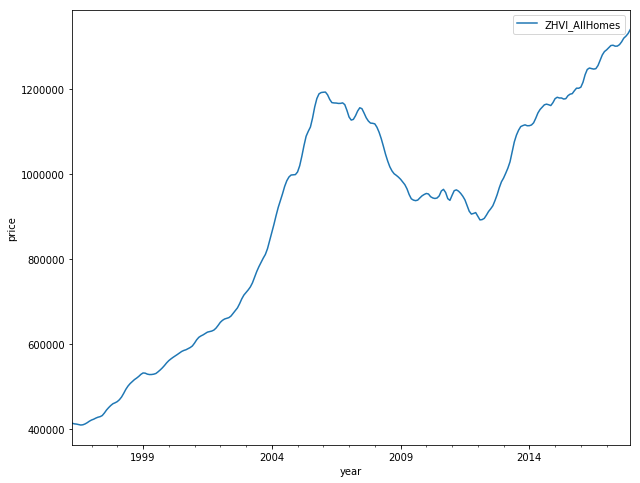

In [6]:
la_allhomes = la.groupby('Date')['Date','ZHVI_AllHomes'].mean().dropna()
la_allhomes.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('price')
plt.show()

In [7]:
train_size = int(len(la_allhomes) * 0.80)
train, test = la_allhomes[0:train_size], la_allhomes[train_size:]
x_train = np.array(train.index).reshape(-1, 1)#.astype('float64')
y_train = np.array(train.values.flatten()).reshape(-1, 1)
x_test = np.array(test.index).reshape(-1, 1)#.astype('float64')
y_test = np.array(test.values.flatten()).reshape(-1, 1)

In [8]:
n_estimators = np.array([10, 100, 200, 1000])
max_depth = np.array([1, 10, 20, 50])
result = []

for idx, i in enumerate(n_estimators):
    result.append([])
    for j in max_depth:
        clf = ensemble.GradientBoostingRegressor(n_estimators = i, max_depth = j, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
        clf.fit(x_train, y_train.ravel())
        res = clf.predict(x_test)
        mape = np.mean(np.abs((res - y_test) / y_test)) * 100
        result[idx].append(mape)
result = np.array(result)
result

array([[21.83811751, 17.48532242, 17.48532242, 17.48532242],
       [17.52611315,  9.65709662,  9.65709662,  9.65709662],
       [13.58315255,  9.65650029,  9.65650031,  9.65650031],
       [ 9.9749644 ,  9.65650027,  9.65650031,  9.65650031]])

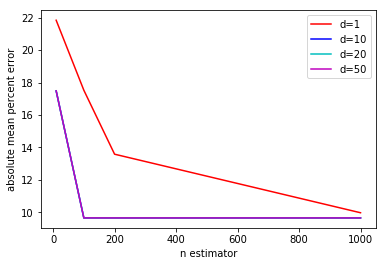

In [9]:
plt.plot(n_estimators, result[:,0], '-r')
plt.plot(n_estimators, result[:,1], '-b')
plt.plot(n_estimators, result[:,2], '-c')
plt.plot(n_estimators, result[:,3], '-m')
plt.xlabel('n estimator')
plt.ylabel('absolute mean percent error')
plt.legend(['d=1', 'd=10', 'd=20', 'd=50'], loc='upper right')
plt.show()

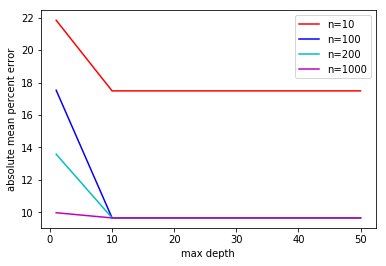

In [10]:
plt.plot(max_depth, result[0, :], '-r')
plt.plot(max_depth, result[1, :], '-b')
plt.plot(max_depth, result[2, :], '-c')
plt.plot(max_depth, result[3, :], '-m')
plt.xlabel('max depth')
plt.ylabel('absolute mean percent error')
plt.legend(['n=10', 'n=100', 'n=200', 'n=1000'], loc='upper right')
plt.show()

In [11]:
result[0, :]

array([21.83811751, 17.48532242, 17.48532242, 17.48532242])

In [12]:
clf = ensemble.GradientBoostingRegressor(n_estimators = 200, max_depth = 20, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
clf.fit(x_train, y_train)
res = clf.predict(x_test)
mape_gbr = np.mean(np.abs((res - y_test) / y_test)) * 100
mape_gbr

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9.656500308660924

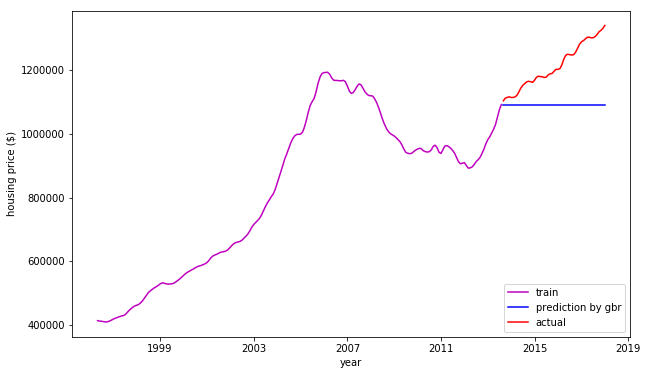

In [13]:

plt.figure(figsize=(10,6))
plt.plot(x_train, y_train, '-m')
plt.plot(x_test, res, '-b')
plt.plot(x_test, y_test, '-r')
#plt.plot(np.array(la_allhomes.index).reshape(-1, 1), res, '-b')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['train', 'prediction by gbr', 'actual'], loc='lower right')
plt.show()

In [14]:
reg = LinearRegression()

In [15]:
reg.fit(x_train.astype('float64'),y_train)
print("coefficient>>>", reg.coef_)
print("intercept>>>", reg.intercept_)

coefficient>>> [[1.27014408e-12]]
intercept>>> [-580568.0093208]


In [16]:
res_lr = reg.predict(np.array(la_allhomes.index).reshape(-1, 1).astype('float64'))

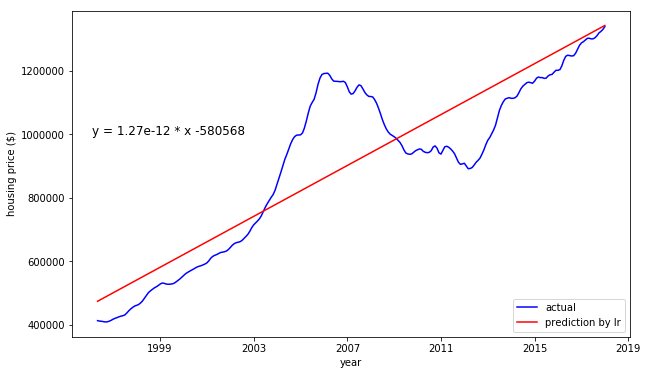

In [18]:
plt.figure(figsize=(10,6))
plt.plot(np.array(la_allhomes.index).reshape(-1, 1), np.array(la_allhomes.values.flatten()).reshape(-1, 1), '-b')
plt.plot(np.array(la_allhomes.index).reshape(-1, 1), res_lr, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['actual', 'prediction by lr'], loc='lower right')
plt.text(x='1996-01-31', y=1000000, s='y = 1.27e-12 * x -580568', fontsize=12)
plt.show()

In [235]:
smoothing_levels = [0.5, 0.7, 0.9, 1]
smoothing_slopes = [0.5, 1, 1.5, 2]
results_a = []
results_b = []

for idx, i in enumerate(smoothing_levels):
    results_a.append([])
    results_b.append([])
    for j in smoothing_slopes:
        modela = ExponentialSmoothing(endog=train)
        modela_fit = modela.fit(smoothing_level=i, smoothing_slope=j, use_boxcox=1.5, use_basinhopping=True)
        y1 = modela_fit.predict(start='2013-08-31', end='2017-12-31')
        mape1 = np.mean(np.abs((y1.values - test['ZHVI_AllHomes']) / test['ZHVI_AllHomes'])) * 100
        results_a[idx].append(mape1)
        
        modelb = ExponentialSmoothing(trend='add', endog=train)
        modelb_fit = modelb.fit(smoothing_level=i, smoothing_slope=j, use_boxcox=1.5, use_basinhopping=True)
        y2 = modelb_fit.predict(start='2013-08-31', end='2017-12-31')
        mape2 = np.mean(np.abs((y2.values - test['ZHVI_AllHomes']) / test['ZHVI_AllHomes'])) * 100
        results_b[idx].append(mape2)

print(results_a)
print(results_b)

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

[[11.174988596336968, 11.174988596336968, 11.174988596336968, 11.174988596336968], [10.292795824671574, 10.292795824671574, 10.292795824671574, 10.292795824671574], [9.810577738189837, 9.810577738189837, 9.810577738189837, 9.810577738189837], [9.656500238331505, 9.656500238331505, 9.656500238331505, 9.656500238331505]]
[[27.821845888067976, 33.82165259941879, 31.26538237445829, 24.14672092064479], [28.107599574898483, 28.530395752108035, 22.02924190407082, 14.675815476005466], [26.622392233359836, 23.524925215441343, 16.631083501448874, 13.429049452629648], [25.6946331104514, 21.716952265440572, 16.294098753160128, 10.147188811155383]]


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [236]:
print(results_a)

[[11.174988596336968, 11.174988596336968, 11.174988596336968, 11.174988596336968], [10.292795824671574, 10.292795824671574, 10.292795824671574, 10.292795824671574], [9.810577738189837, 9.810577738189837, 9.810577738189837, 9.810577738189837], [9.656500238331505, 9.656500238331505, 9.656500238331505, 9.656500238331505]]


In [237]:
print(results_b)

[[27.821845888067976, 33.82165259941879, 31.26538237445829, 24.14672092064479], [28.107599574898483, 28.530395752108035, 22.02924190407082, 14.675815476005466], [26.622392233359836, 23.524925215441343, 16.631083501448874, 13.429049452629648], [25.6946331104514, 21.716952265440572, 16.294098753160128, 10.147188811155383]]


In [238]:
results_a = np.array(results_a)
results_b = np.array(results_b)

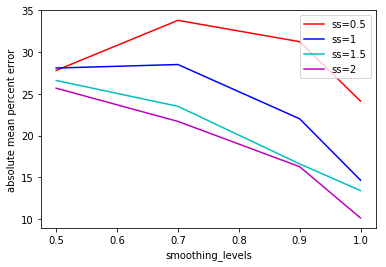

In [239]:
plt.plot(smoothing_levels, results_b[0,:], '-r')
plt.plot(smoothing_levels, results_b[1,:], '-b')
plt.plot(smoothing_levels, results_b[2,:], '-c')
plt.plot(smoothing_levels, results_b[3,:], '-m')
plt.xlabel('smoothing_levels')
plt.ylabel('absolute mean percent error')
plt.legend(['ss=0.5', 'ss=1', 'ss=1.5', 'ss=2'], loc='upper right')
plt.show()

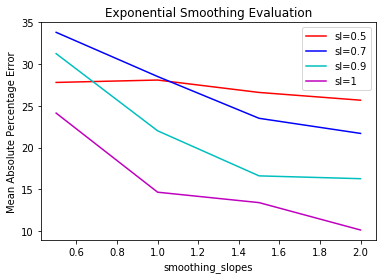

In [241]:
plt.plot(smoothing_slopes, results_b[:,0], '-r')
plt.plot(smoothing_slopes, results_b[:,1], '-b')
plt.plot(smoothing_slopes, results_b[:,2], '-c')
plt.plot(smoothing_slopes, results_b[:,3], '-m')
plt.xlabel('smoothing_slopes')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend(['sl=0.5', 'sl=0.7', 'sl=0.9', 'sl=1'], loc='upper right')
plt.title('Exponential Smoothing Evaluation')
plt.show()

In [219]:
expo_model = ExponentialSmoothing(trend='add',endog=train)
model_expo_fit = expo_model.fit(smoothing_level=1, smoothing_slope=2, use_boxcox=1.5, use_basinhopping=True)
y_pred = model_expo_fit.predict(start ='2013-08-31', end='2017-12-31')
y_forecast = model_expo_fit.predict(start ='2017-12-31', end='2018-12-31')


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [220]:
mapetest = np.mean(np.abs((y_pred.values - test['ZHVI_AllHomes']) / test['ZHVI_AllHomes'])) * 100
mapetest

10.147188811155383

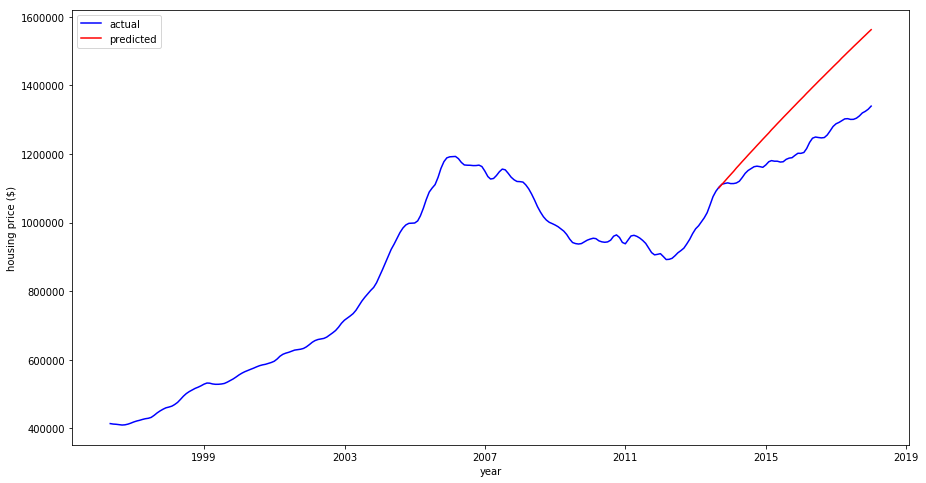

In [221]:
#ax = la_allhomes.plot(label='Actual', figsize=(15,8))
#y_pred.plot(ax=ax, label='Predict', alpha=0.7, color='red')
#y_forecast.plot(ax=ax, label='Forecast', alpha=0.8, color='magenta')
#plt.legend()
plt.figure(figsize=(15,8))
plt.plot(la_allhomes.index, la_allhomes.values.flatten(), '-b')
plt.plot(x_test, y_pred, '-r')
plt.xlabel('year')
plt.ylabel('housing price ($)')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [222]:
los_altos_allhomes = los_altos.groupby('Date')['Date','ZHVI_AllHomes'].mean().dropna()
palo_alto_allhomes = palo_alto.groupby('Date')['Date','ZHVI_AllHomes'].mean().dropna()
saratoga_allhomes = saratoga.groupby('Date')['Date','ZHVI_AllHomes'].mean().dropna()
menlo_park_allhomes = menlo_park.groupby('Date')['Date','ZHVI_AllHomes'].mean().dropna()

In [223]:
train_los_altos, test_los_altos = los_altos_allhomes[0:train_size], los_altos_allhomes[train_size:]
x_train_los_altos = np.array(train_los_altos.index).reshape(-1, 1)#.astype('float64')
y_train_los_altos = np.array(train_los_altos.values.flatten()).reshape(-1, 1)
x_test_los_altos = np.array(test_los_altos.index).reshape(-1, 1)#.astype('float64')
y_test_los_altos = np.array(test_los_altos.values.flatten()).reshape(-1, 1)

train_palo_alto, test_palo_alto = palo_alto_allhomes[0:train_size], palo_alto_allhomes[train_size:]
x_train_palo_alto = np.array(train_palo_alto.index).reshape(-1, 1)#.astype('float64')
y_train_palo_alto = np.array(train_palo_alto.values.flatten()).reshape(-1, 1)
x_test_palo_alto = np.array(test_palo_alto.index).reshape(-1, 1)#.astype('float64')
y_test_palo_alto = np.array(test_palo_alto.values.flatten()).reshape(-1, 1)

train_saratoga, test_saratoga = saratoga_allhomes[0:train_size], saratoga_allhomes[train_size:]
x_train_saratoga = np.array(train_saratoga.index).reshape(-1, 1)#.astype('float64')
y_train_saratoga = np.array(train_saratoga.values.flatten()).reshape(-1, 1)
x_test_saratoga = np.array(test_saratoga.index).reshape(-1, 1)#.astype('float64')
y_test_saratoga = np.array(test_saratoga.values.flatten()).reshape(-1, 1)

train_menlo_park, test_menlo_park = menlo_park_allhomes[0:train_size], menlo_park_allhomes[train_size:]
x_train_menlo_park = np.array(train_menlo_park.index).reshape(-1, 1)#.astype('float64')
y_train_menlo_park = np.array(train_menlo_park.values.flatten()).reshape(-1, 1)
x_test_menlo_park = np.array(test_menlo_park.index).reshape(-1, 1)#.astype('float64')
y_test_menlo_park = np.array(test_menlo_park.values.flatten()).reshape(-1, 1)

In [224]:
expo_model_los_altos = ExponentialSmoothing(trend='add', endog=train_los_altos)
model_expo_fit_los_altos = expo_model_los_altos.fit(smoothing_level=1, smoothing_slope=2, use_boxcox=1.5, use_basinhopping=True)
y_pred_los_altos = model_expo_fit_los_altos.predict(start='2013-08-31', end='2017-12-31')
y_forecast_los_altos = model_expo_fit_los_altos.predict(start = '2017-12-31', end='2018-12-31')


expo_model_palo_alto = ExponentialSmoothing(trend='add', endog=train_palo_alto)
model_expo_fit_palo_alto = expo_model_palo_alto.fit(smoothing_level=1, smoothing_slope=2, use_boxcox=1.5, use_basinhopping=True)
y_pred_palo_alto = model_expo_fit_palo_alto.predict(start='2013-08-31', end='2017-12-31')
y_forecast_palo_alto = model_expo_fit_palo_alto.predict(start = '2017-12-31', end='2018-12-31')

expo_model_saratoga = ExponentialSmoothing(trend='add', endog=train_saratoga)
model_expo_fit_saratoga = expo_model_saratoga.fit(smoothing_level=1, smoothing_slope=2, use_boxcox=1.5, use_basinhopping=True)
y_pred_saratoga = model_expo_fit_saratoga.predict(start='2013-08-31', end='2017-12-31')
y_forecast_saratoga = model_expo_fit_saratoga.predict(start = '2017-12-31', end='2018-12-31')

expo_model_menlo_park = ExponentialSmoothing(trend='add', endog=train_menlo_park)
model_expo_fit_menlo_park = expo_model_menlo_park.fit(smoothing_level=1, smoothing_slope=2, use_boxcox=1.5, use_basinhopping=True)
y_pred_menlo_park = model_expo_fit_menlo_park.predict(start='2013-08-31', end='2017-12-31')
y_forecast_menlo_park = model_expo_fit_menlo_park.predict(start = '2017-12-31', end='2018-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

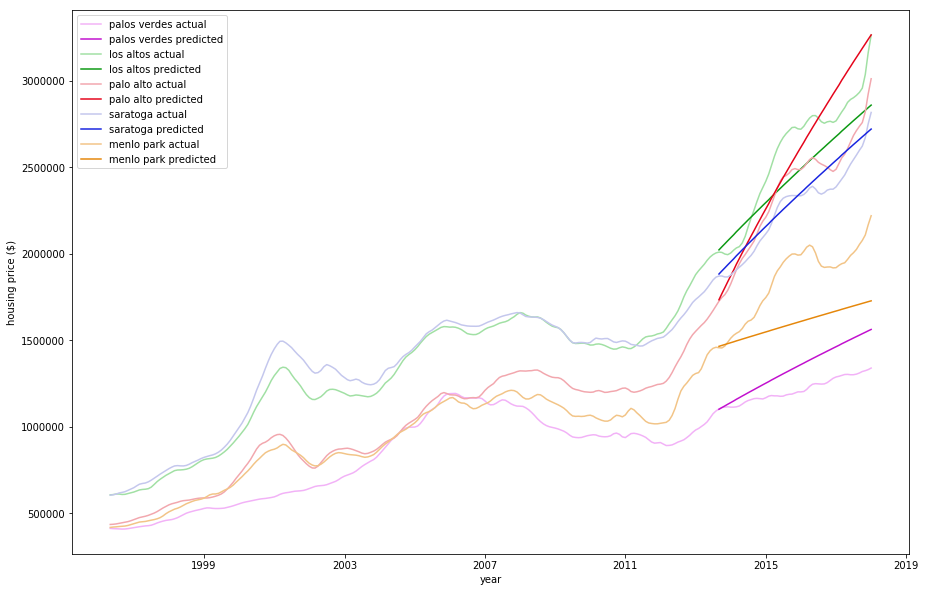

In [225]:


plt.figure(figsize=(15,10))
plt.plot(la_allhomes.index, la_allhomes.values.flatten(), '#f2b2f7')
plt.plot(x_test, y_pred, '#c110ce')
plt.xlabel('year')
plt.ylabel('housing price ($)')


plt.plot(los_altos_allhomes.index, los_altos_allhomes.values.flatten(), '#a1e0a4')
plt.plot(x_test_los_altos, y_pred_los_altos, '#0c9913')


plt.plot(palo_alto_allhomes.index, palo_alto_allhomes.values.flatten(), '#f2a7ae')
plt.plot(x_test_palo_alto, y_pred_palo_alto, '#e5041b')


plt.plot(saratoga_allhomes.index, saratoga_allhomes.values.flatten(), '#c4c7ed')
plt.plot(x_test_saratoga, y_pred_saratoga, '#1824e0')


plt.plot(menlo_park_allhomes.index, menlo_park_allhomes.values.flatten(), '#f2c487')
plt.plot(x_test_menlo_park, y_pred_menlo_park, '#e5870b')



plt.legend(['palos verdes actual', 'palos verdes predicted', 'los altos actual', 'los altos predicted', 'palo alto actual', 'palo alto predicted', 'saratoga actual', 'saratoga predicted', 'menlo park actual', 'menlo park predicted'], loc='upper left')
plt.show()

In [226]:
mape_los_altos = np.mean(np.abs((y_pred_los_altos.values - test_los_altos['ZHVI_AllHomes']) / test_los_altos['ZHVI_AllHomes'])) * 100

In [227]:
mape_palo_alto = np.mean(np.abs((y_pred_palo_alto.values - test_palo_alto['ZHVI_AllHomes']) / test_palo_alto['ZHVI_AllHomes'])) *100

In [228]:
mape_saratoga = np.mean(np.abs((y_pred_saratoga.values - test_saratoga['ZHVI_AllHomes']) / test_saratoga['ZHVI_AllHomes'])) * 100

In [229]:
mape_menlo_park = np.mean(np.abs((y_pred_menlo_park.values - test_menlo_park['ZHVI_AllHomes']) / test_menlo_park['ZHVI_AllHomes'])) * 100

In [230]:
mape_la = np.mean(np.abs((y_pred.values - test['ZHVI_AllHomes']) / test['ZHVI_AllHomes'])) * 100

In [231]:
print("la>>>", mape_la)
print("los altos>>>", mape_los_altos)
print("palo alto>>>", mape_palo_alto)
print("saratoga>>>", mape_saratoga)
print("menlo_park>>>", mape_menlo_park)

la>>> 10.147188811155383
los altos>>> 5.870730498080995
palo alto>>> 7.0492493197759
saratoga>>> 3.034588425695289
menlo_park>>> 13.036578038271657


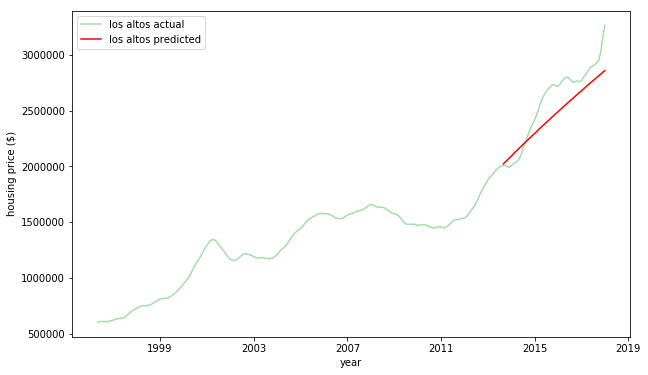

In [232]:
plt.figure(figsize=(10,6))




plt.plot(los_altos_allhomes.index, los_altos_allhomes.values.flatten(), '#a1e0a4')
plt.plot(x_test_los_altos, y_pred_los_altos, '-r')



plt.xlabel('year')
plt.ylabel('housing price ($)')

plt.legend(['los altos actual', 'los altos predicted'], loc='upper left')
plt.show()